

# Alexa Project Code Contribution

> Author: Chet (techds on GitHub)  
> * Transfer Learning and CNN:  
>   * image data ingestion (VGG16 bottleneck features via image data generator)  
>   * model prediction  


In [1]:
# imports

import numpy as np
np.random.seed(200) 
import tensorflow as tf
from tensorflow import set_random_seed 
set_random_seed(300)

from keras import applications
from keras import optimizers
from keras.callbacks import ModelCheckpoint, Callback, \
                            CSVLogger, EarlyStopping, TensorBoard
from keras.layers import AveragePooling2D, BatchNormalization, Conv2D, \
                         MaxPooling2D, Dense, Dropout, Activation, Flatten,\
                         ZeroPadding2D
from keras.models import load_model, Sequential
from keras.preprocessing import image
from keras.preprocessing.image import array_to_img, img_to_array, load_img,\
                                      ImageDataGenerator
from keras.utils import to_categorical
from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.utils import shuffle as sh

import warnings
warnings.filterwarnings('ignore')

import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from pydub import AudioSegment as audio
from pydub.playback import play 
import re
import time

# functions

def plot_loss_acc(hist):
    f, ax = plt.subplots()
    ax.plot([None] + hist.history['acc'], 'o-', c='r')
    ax.plot([None] + hist.history['val_acc'], '*-', c='g')
    ax.legend(['Train acc', 'Val acc'], loc = 0)
    ax.set_title('Training/Validation Accuracy per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy') 
    plt.plot()
    
    f, ax = plt.subplots()
    ax.plot([None] + hist.history['loss'], 'o-', c='r')
    ax.plot([None] + hist.history['val_loss'], '*-', c='g')
    ax.legend(['Train loss', 'Val loss'], loc = 0)
    ax.set_title('Training/Validation Loss per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss') 
    plt.plot()
    
def tag_cols(df,beg_str,last_col_name):
    colnames = []
    beg_str = str(beg_str)
    len_col = len(df.columns)
    for l in range(len_col-1 ):
        name = beg_str + str(l+1)
        colnames.append(name)
    last_col_name = str(last_col_name)
    colnames.append(last_col_name)
    df.columns = colnames
    
print('Ready for data ingestion and model prediction')


Using TensorFlow backend.


Ready for data ingestion and model prediction


In [3]:
# instantiate vars:
img_width, img_height = 150, 102  
n_tr_samples = 750
n_vl_samples = 150
n_te_samples = 10   
n_epochs = 20
out = n_te_samples 

# set dir paths
trn_dir = './Desktop/nn_audio/trn/'
val_dir = './Desktop/nn_audio/val/'
tst_dir = './Desktop/nn_audio/tst/'

print('Data paths set')


Data paths set


In [4]:
# read images in dirs and generate batches of image data 

datagen = ImageDataGenerator(rescale=1./255)
tr_gen = datagen.flow_from_directory(
            directory=trn_dir,                             
            target_size=(img_width, img_height), 
            batch_size=32,
            class_mode='categorical',   
            shuffle=False) 

tr_lab = tr_gen.classes
num_lab = len(np.unique(tr_lab))
spk_idx = tr_gen.class_indices
print('\n',spk_idx)


Found 750 images belonging to 10 classes.

 {'anderson': 0, 'chet': 1, 'jack': 2, 'ken': 3, 'meghan': 4, 'mikio': 5, 'pooja': 6, 'rachel': 7, 'rene': 8, 'serhad': 9}


In [5]:
vl_gen = datagen.flow_from_directory(
            val_dir,                            
            target_size=(img_width, img_height),
            batch_size=32,
            class_mode='categorical',  
            shuffle=False)

val_imgs = []
speakers = [] 
for path,subdirs,files in os.walk(val_dir):
    for subdir in subdirs:
        speakers.append(subdir)
        folder_path = os.path.join(val_dir + subdir + '/')
        folder_path = ''.join(folder_path)
        for files in os.listdir(folder_path):
            if files.endswith('.jpg'):
                val_imgs.append(files)

speakers = sorted(speakers)
print(speakers) 


Found 150 images belonging to 10 classes.
['anderson', 'chet', 'jack', 'ken', 'meghan', 'mikio', 'pooja', 'rachel', 'rene', 'serhad']


In [6]:
# load the saved VGG16 bottleneck features for train, val, and test images

x_tr = np.load(trn_dir + 'features_audio_trn.npy')
x_vl = np.load(val_dir + 'features_audio_val.npy')
x_te = np.load(tst_dir + 'features_audio_tst.npy') 

print('train data shape: ', x_tr.shape, '\n', 'val data shape : ', x_vl.shape,\
      '\n', 'test data shape: ',  x_te.shape)


train data shape:  (750, 4, 3, 512) 
 val data shape :  (150, 4, 3, 512) 
 test data shape:  (10, 4, 3, 512)


In [7]:
# create labels
y_tr = np.array([0] * (n_tr_samples // out) + [1] * (n_tr_samples // out) + \
                [2] * (n_tr_samples // out) + [3] * (n_tr_samples // out) + \
                [4] * (n_tr_samples // out) + [5] * (n_tr_samples // out) + \
                [6] * (n_tr_samples // out) + [7] * (n_tr_samples // out) + \
                [8] * (n_tr_samples // out) + [9] * (n_tr_samples // out) )

y_vl = np.array([0] * (n_vl_samples // out) + [1] * (n_vl_samples // out) + \
                [2] * (n_vl_samples // out) + [3] * (n_vl_samples // out) + \
                [4] * (n_vl_samples // out) + [5] * (n_vl_samples // out) + \
                [6] * (n_vl_samples // out) + [7] * (n_vl_samples // out) + \
                [8] * (n_vl_samples // out) + [9] * (n_vl_samples // out) )


y_te = np.array([0] * (n_te_samples // out) + [1] * (n_te_samples // out) + \
                [2] * (n_te_samples // out) + [3] * (n_te_samples // out) + \
                [4] * (n_te_samples // out) + [5] * (n_te_samples // out) + \
                [6] * (n_te_samples // out) + [7] * (n_te_samples // out) + \
                [8] * (n_te_samples // out) + [9] * (n_te_samples // out) )
print(y_te)


[0 1 2 3 4 5 6 7 8 9]


In [8]:
y_tr_cat = to_categorical(y_tr)
y_vl_cat = to_categorical(y_vl)
y_te_cat = to_categorical(y_te)

input_tensor = (64, 32, 3)
x_tr = x_tr.reshape((x_tr.shape[0],) + input_tensor) 
x_vl = x_vl.reshape((x_vl.shape[0],) + input_tensor)
x_te = x_te.reshape((x_te.shape[0],) + input_tensor)

print('train data shape: ', x_tr.shape, '\n', 'val data shape : ', x_vl.shape,\
      '\n', 'test data shape: ',  x_te.shape)


train data shape:  (750, 64, 32, 3) 
 val data shape :  (150, 64, 32, 3) 
 test data shape:  (10, 64, 32, 3)


In [10]:
# feed the image feature arrays to the CNN (mod1)

mod1 = Sequential()

mod1.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_tensor))
 
mod1.add(AveragePooling2D())

mod1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
mod1.add(AveragePooling2D())

mod1.add(Flatten())
mod1.add(Dense(units=120, activation='relu'))

mod1.add(Dense(units=84, activation='relu'))

mod1.add(Dense(out))
mod1.add(Activation(tf.nn.softmax))

mod1.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 30, 6)         168       
_________________________________________________________________
average_pooling2d_1 (Average (None, 31, 15, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 13, 16)        880       
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 6, 16)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1344)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               161400    
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10164     
__________

In [11]:
# compile and fit the model
mod1.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer='adam')

hist_mod1_vgg16 = mod1.fit(x_tr, y_tr_cat,
                            batch_size = 32,
                            epochs = n_epochs,
                            validation_data = (x_vl, y_vl_cat))


Train on 750 samples, validate on 150 samples
Epoch 1/20
750/750 [==============================] - 1s 2ms/step - loss: 2.3070 - acc: 0.1173 - val_loss: 2.2917 - val_acc: 0.1067
Epoch 2/20
750/750 [==============================] - 1s 1ms/step - loss: 2.2810 - acc: 0.1947 - val_loss: 2.2497 - val_acc: 0.2400
Epoch 3/20
750/750 [==============================] - 1s 2ms/step - loss: 2.1943 - acc: 0.2507 - val_loss: 2.0531 - val_acc: 0.3467
Epoch 4/20
750/750 [==============================] - 1s 1ms/step - loss: 1.8825 - acc: 0.3800 - val_loss: 1.7276 - val_acc: 0.4000
Epoch 5/20
750/750 [==============================] - 1s 1ms/step - loss: 1.5967 - acc: 0.3893 - val_loss: 1.5325 - val_acc: 0.5467
Epoch 6/20
750/750 [==============================] - 1s 1ms/step - loss: 1.3204 - acc: 0.5360 - val_loss: 1.2585 - val_acc: 0.5533
Epoch 7/20
750/750 [==============================] - 1s 2ms/step - loss: 1.1324 - acc: 0.6120 - val_loss: 1.1140 - val_acc: 0.6467
Epoch 8/20
750/750 [==========

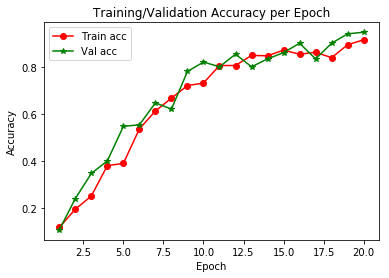

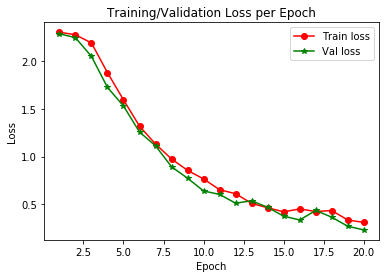

In [12]:
plot_loss_acc(hist_mod1_vgg16)


In [13]:
# access and authenticate voice command

datagen = ImageDataGenerator(rescale=1./255)
pred_dir = './Desktop/nn_audio/chk/'
pred_imgs = []
for files in os.listdir(pred_dir + '/' + 'speaker'):
    if files.endswith('.jpg'):
        pred_imgs.append(files)
print(pred_imgs)
num_pred = len(pred_imgs)


['plot_audio_m.jpg']


In [14]:
print('Authenticating...\n')
batch_size = 1
te_gen = datagen.flow_from_directory(
                    directory=pred_dir,
                    target_size=(64, 32),
                    #color_mode='rgb',
                    batch_size=batch_size,
                    class_mode=None,
                    shuffle=False)


Authenticating...

Found 1 images belonging to 1 classes.


In [15]:
te_gen.reset()
pred = mod1.predict_generator(te_gen, verbose=1, 
                              steps=num_pred/batch_size)


1/1 [==============================] - 0s 134ms/step


In [16]:
pred_rs = pred.reshape(len(speakers),1)
pred_df = pd.DataFrame(list(map(np.ravel, pred_rs)))
pred_df.columns = ['f']
pred_ls = np.array(pred_df['f'].tolist())

prob_thresh = .95
max_prob = np.max(pred_ls)
max_prob_val = round(max_prob * 100,2)
max_prob_ind = pred_ls.tolist().index(max_prob) 
pred_label = speakers[max_prob_ind]
pred_label = re.sub('\_(.*)','', pred_label)

print('I\'m %s%% sure that you are %s.'\
      % (max_prob_val, pred_label.upper()) )


I'm 96.36% sure that you are RACHEL.
